<a href="https://colab.research.google.com/github/ifymifan/IOT-AI/blob/main/second_lab4_Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
# mount google drive on Colab
from google.colab import drive
drive.mount('/content/drive')

import os
import json
import torchaudio

## import data! - Training data

# Set data paths
data_root = '/content/drive/MyDrive/Second_lab4'
training_folder = os.path.join(data_root, 'training')

# Load info.labels file #corrected to be a comment
with open(os.path.join(training_folder, 'info.labels'), 'r') as f:
    label_data = json.load(f)

# Get filenames and labels
wav_files = []
labels = []
for file_info in label_data['files']:
    # Construct the full file path using os.path.join and add .wav extension
    wav_file_path = os.path.join(training_folder, file_info['path'])
    print(wav_file_path)
    # Check if the file exists before adding it to the list
    if os.path.exists(wav_file_path):
        wav_files.append(wav_file_path)
        labels.append(file_info['label']['label'])
    else:
        print(f"Warning: File not found: {wav_file_path}")
        print(file_info['label']['label'])


# Load waveforms
waveforms = []
for wav_file in wav_files:
    print(wav_file)
    waveform, sample_rate = torchaudio.load(wav_file)
    waveforms.append(waveform)

 #Print the first few filenames and labels to verify
for i in range(min(5,len(wav_files))):#added the min clause to make it run even if less than 5 files
    print(f"Filename: {wav_files[i]}, Label: {labels[i]}")
    #print_stats(waveforms[i], sample_rate) #commented out because these function were not defined
    #plot_waveform(waveforms[i], sample_rate) #commented out because these function were not defined



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Second_lab4/training/Apple.5kmsuo82.ingestion-6c76ddf756-9ph4z.s20.wav
/content/drive/MyDrive/Second_lab4/training/Apple.5kmsuo82.ingestion-6c76ddf756-9ph4z.s19.wav
/content/drive/MyDrive/Second_lab4/training/Apple.5kmsuo82.ingestion-6c76ddf756-9ph4z.s18.wav
/content/drive/MyDrive/Second_lab4/training/Apple.5kmsuo82.ingestion-6c76ddf756-9ph4z.s17.wav
/content/drive/MyDrive/Second_lab4/training/Apple.5kmsuo82.ingestion-6c76ddf756-9ph4z.s16.wav
/content/drive/MyDrive/Second_lab4/training/Apple.5kmsuo82.ingestion-6c76ddf756-9ph4z.s15.wav
/content/drive/MyDrive/Second_lab4/training/Apple.5kmsuo82.ingestion-6c76ddf756-9ph4z.s14.wav
/content/drive/MyDrive/Second_lab4/training/Apple.5kmsuo82.ingestion-6c76ddf756-9ph4z.s13.wav
/content/drive/MyDrive/Second_lab4/training/Apple.5kmsuo82.ingestion-6c76ddf756-9ph4z.s12.wav
/content/drive/MyDrive/Se

In [31]:
# mount google drive on Colab
from google.colab import drive
drive.mount('/content/drive')

import os
import json
import torchaudio

## import data! - Training data

# Set data paths
data_root = '/content/drive/MyDrive/Second_lab4'
training_folder = os.path.join(data_root, 'training')

# Load info.labels file
with open(os.path.join(training_folder, 'info.labels'), 'r') as f:
    label_data = json.load(f)

# Get filenames and labels
wav_files = []
labels = []
for file_info in label_data['files']:
    # Construct the full file path using os.path.join and add .wav extension
    wav_file_path = os.path.join(training_folder, file_info['path'])
    print(wav_file_path)
    # Check if the file exists before adding it to the list
    if os.path.exists(wav_file_path):
        wav_files.append(wav_file_path)
        labels.append(file_info['label']['label'])
    else:
        print(f"Warning: File not found: {wav_file_path}")
        print(file_info['label']['label'])


# Load waveforms
waveforms = []
for wav_file in wav_files:
    print(wav_file)
    waveform, sample_rate = torchaudio.load(wav_file)
    waveforms.append(waveform)

 #Print the first few filenames and labels to verify
for i in range(min(5,len(wav_files))):#added the min clause to make it run even if less than 5 files
    print(f"Filename: {wav_files[i]}, Label: {labels[i]}")

# Define functions for stats and plotting
def print_stats(waveform, sample_rate):
    """Prints waveform statistics."""
    print("Shape:", tuple(waveform.shape))
    print("Sample Rate:", sample_rate)
    print("Dtype:", waveform.dtype)
    print(f"Min: {waveform.min().item()}, Max: {waveform.max().item()}")
    print(f"Mean: {waveform.mean().item()}, Std: {waveform.std().item()}")

def plot_waveform(waveform, sample_rate, title="Waveform"):
    """Plots the waveform."""
    import matplotlib.pyplot as plt
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
    figure.suptitle(title)
    plt.show(block=False)

#Print the first few filenames and labels to verify and show stats and plots
for i in range(min(5,len(wav_files))):
    print(f"Filename: {wav_files[i]}, Label: {labels[i]}")
    print_stats(waveforms[i], sample_rate)
    plot_waveform(waveforms[i], sample_rate)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Second_lab4/training/Apple.5kmsuo82.ingestion-6c76ddf756-9ph4z.s20.wav
/content/drive/MyDrive/Second_lab4/training/Apple.5kmsuo82.ingestion-6c76ddf756-9ph4z.s19.wav
/content/drive/MyDrive/Second_lab4/training/Apple.5kmsuo82.ingestion-6c76ddf756-9ph4z.s18.wav
/content/drive/MyDrive/Second_lab4/training/Apple.5kmsuo82.ingestion-6c76ddf756-9ph4z.s17.wav
/content/drive/MyDrive/Second_lab4/training/Apple.5kmsuo82.ingestion-6c76ddf756-9ph4z.s16.wav
/content/drive/MyDrive/Second_lab4/training/Apple.5kmsuo82.ingestion-6c76ddf756-9ph4z.s15.wav
/content/drive/MyDrive/Second_lab4/training/Apple.5kmsuo82.ingestion-6c76ddf756-9ph4z.s14.wav
/content/drive/MyDrive/Second_lab4/training/Apple.5kmsuo82.ingestion-6c76ddf756-9ph4z.s13.wav
/content/drive/MyDrive/Second_lab4/training/Apple.5kmsuo82.ingestion-6c76ddf756-9ph4z.s12.wav
/content/drive/MyDrive/Se

NameError: name 'torch' is not defined

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

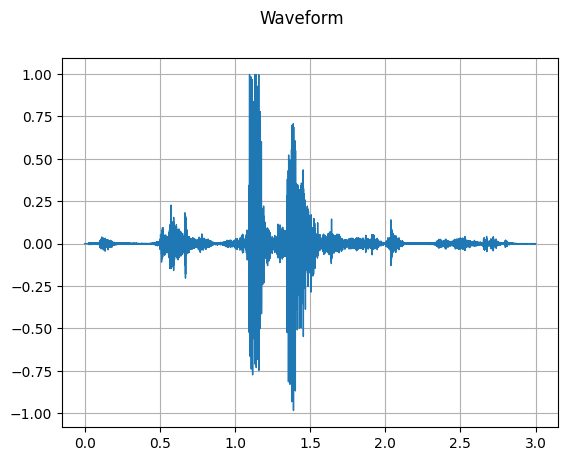

Filename: /content/drive/MyDrive/Second_lab4/training/Apple.5kmsuo82.ingestion-6c76ddf756-9ph4z.s19.wav, Label: Apple
Sample Rate: 16000
Shape: (1, 48000)
Dtype: torch.float32
Min: -0.940643310546875, Max: 0.725921630859375
Mean: 9.570439942763187e-06, Std: 0.05283170938491821



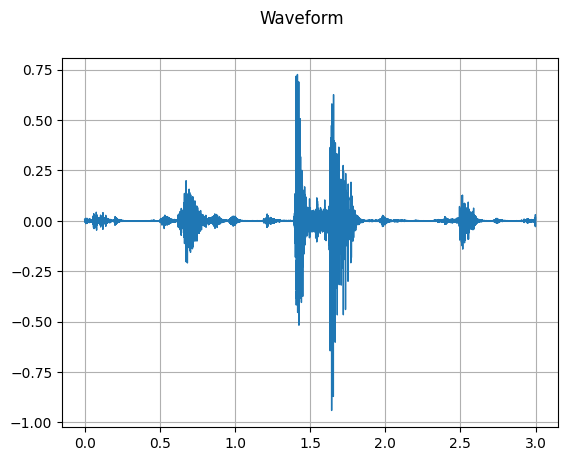

Filename: /content/drive/MyDrive/Second_lab4/training/Apple.5kmsuo82.ingestion-6c76ddf756-9ph4z.s18.wav, Label: Apple
Sample Rate: 16000
Shape: (1, 48000)
Dtype: torch.float32
Min: -0.645782470703125, Max: 0.999969482421875
Mean: 1.8905639080912806e-05, Std: 0.05649444833397865



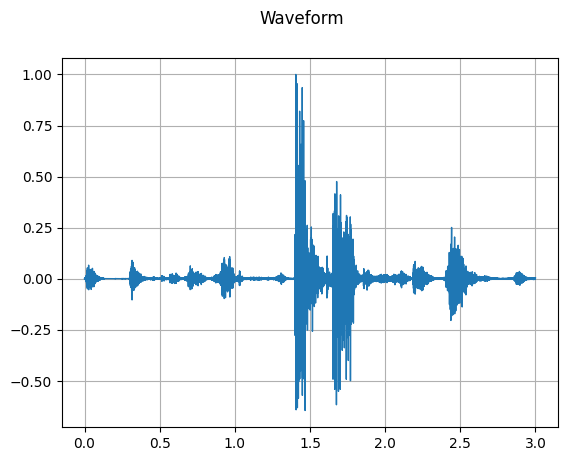

Filename: /content/drive/MyDrive/Second_lab4/training/Apple.5kmsuo82.ingestion-6c76ddf756-9ph4z.s17.wav, Label: Apple
Sample Rate: 16000
Shape: (1, 48000)
Dtype: torch.float32
Min: -0.952301025390625, Max: 0.99664306640625
Mean: 5.7449342421023175e-06, Std: 0.06733158975839615



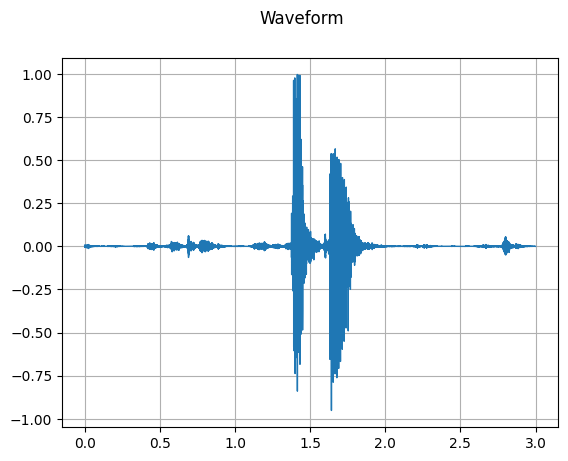

Filename: /content/drive/MyDrive/Second_lab4/training/Apple.5kmsuo82.ingestion-6c76ddf756-9ph4z.s16.wav, Label: Apple
Sample Rate: 16000
Shape: (1, 48000)
Dtype: torch.float32
Min: -0.813812255859375, Max: 0.98712158203125
Mean: 2.1429697881103493e-05, Std: 0.058473095297813416



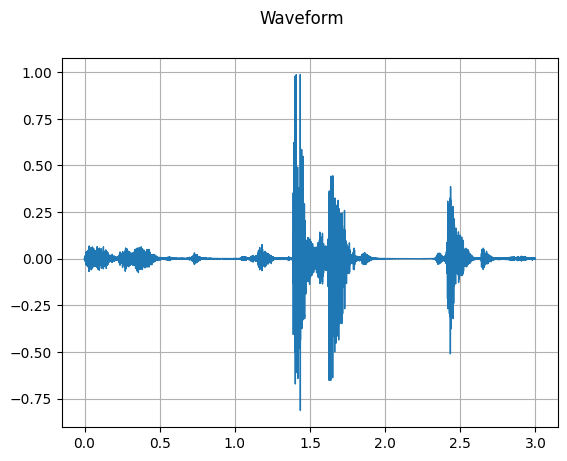

In [32]:
!pip install torchaudio
!pip install torch
!pip install matplotlib

# mount google drive on Colab
from google.colab import drive
drive.mount('/content/drive')

import os
import json
import torchaudio
import torch # import torch
import matplotlib.pyplot as plt #Import matplotlib here

## import data! - Training data

# Set data paths
data_root = '/content/drive/MyDrive/Second_lab4'
training_folder = os.path.join(data_root, 'training')

# Make sure the directory exists
if not os.path.exists(training_folder):
  print(f"Error: Directory not found: {training_folder}")
else:
  # Load info.labels file
  with open(os.path.join(training_folder, 'info.labels'), 'r') as f:
      label_data = json.load(f)

  # Get filenames and labels
  wav_files = []
  labels = []
  for file_info in label_data['files']:
      # Construct the full file path using os.path.join
      wav_file_path = os.path.join(training_folder, file_info['path'])
      print(wav_file_path)
      # Check if the file exists before adding it to the list
      if os.path.exists(wav_file_path):
          wav_files.append(wav_file_path)
          labels.append(file_info['label']['label'])
      else:
          print(f"Warning: File not found: {wav_file_path}")
          print(file_info['label']['label'])


  # Load waveforms
  waveforms = []
  sample_rates = [] # We need to save the sample_rates
  for wav_file in wav_files:
      print(wav_file)
      try:
          waveform, sample_rate = torchaudio.load(wav_file)
          waveforms.append(waveform)
          sample_rates.append(sample_rate) #Append the rate
      except Exception as e:
          print(f"Warning: Could not load waveform from {wav_file}. Error: {e}")

  # Define functions for stats and plotting
  def print_stats(waveform, sample_rate, src=None): #We removed the duplicate function definition and updated this
      """Prints waveform statistics."""
      if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
      if sample_rate:
          print("Sample Rate:", sample_rate)
      print("Shape:", tuple(waveform.shape))
      print("Dtype:", waveform.dtype)
      print(f"Min: {waveform.min().item()}, Max: {waveform.max().item()}")
      print(f"Mean: {waveform.mean().item()}, Std: {waveform.std().item()}")
      print()

  def plot_waveform(waveform, sample_rate, title="Waveform"):
      """Plots the waveform."""
      waveform = waveform.numpy()

      num_channels, num_frames = waveform.shape
      time_axis = torch.arange(0, num_frames) / sample_rate #torch is being used so we needed to explicitly import it

      figure, axes = plt.subplots(num_channels, 1)
      if num_channels == 1:
          axes = [axes]
      for c in range(num_channels):
          axes[c].plot(time_axis, waveform[c], linewidth=1)
          axes[c].grid(True)
          if num_channels > 1:
              axes[c].set_ylabel(f'Channel {c+1}')
      figure.suptitle(title)
      plt.show(block=False)

  #Print the first few filenames and labels to verify and show stats and plots
  for i in range(min(5,len(wav_files))):
      print(f"Filename: {wav_files[i]}, Label: {labels[i]}")
      print_stats(waveforms[i], sample_rates[i]) #Now we need to pull the sample rate from the list we made
      plot_waveform(waveforms[i], sample_rates[i]) #Now we need to pull the sample rate from the list we made